![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# TFM - Modelo Baseline de Regresión



# **_1. Librerías y configuración_**

In [1]:
# Principales

import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Modificaciones
import re
import unicodedata
import datetime
import os
import math

# visuzalizaciones

import missingno as msno
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
from sklearn.datasets import fetch_california_housing

import gc
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from xgboost import XGBRegressor

In [2]:
# Forzar la recolección de basura
gc.collect()

0

In [3]:
pd.set_option('display.max_info_columns',110 )
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',80)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
# Ajustar la configuración para mostrar más filas
# pd.set_option('display.max_rows', 500)

# Inicializar la lista to replace
to_replace=['Null','Nan','nan','NULL',None]

# **_2. Funciones_**

In [4]:
#Funcion que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    boolean_columns=[col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    numeric_cols=int_columns + float_columns
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()

    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas
    all_columns = set(df.columns)
    # # Columnas de otros tipos
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))

    # Cuento el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    print("Número de columnas de tipo entero:", num_int_columns)
    print("Columnas de tipo entero:", int_columns)
    print("Número de columnas de tipo float:", num_float_columns)
    print("Columnas de tipo float:", float_columns)
    print("Número de columnas de tipo object:", num_object_columns)
    print("Columnas de tipo object:", object_columns)
    print("Número de columnas de tipo category:", num_category_columns)
    print("Columnas de tipo category:", category_columns)
    print("Número de columnas de otros tipos:", num_other_columns)
    print("Columnas de otros tipos:", other_columns)
    return boolean_columns,numeric_cols,cat_columns,object_columns,other_columns

In [5]:

def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir.
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False.

    Returns
    -------
    pd.DataFrame
        Dataframe optimizado.
    """

    start_mem = df.memory_usage().sum() / 1024**2  # Memoria inicial

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                # Conversión de float a int si no hay decimales y no hay NaN
                df[col] = df[col].fillna(0)  # Rellenar NaN antes de verificar si son enteros
                if all(df[col].apply(float.is_integer)):
                    df[col] = df[col].astype(np.int64)

        # Conversión de objetos a categoría si turn_cat es True
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # Memoria final

    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [6]:
#def diccionario_mediana(df,colnulos,colagrup1,colagrup2):
 #   mediana = (df[df[colagrup1].notnull() & dfEDA[colnulos].notnull() ]
  #  .groupby([colagrup1, colagrup2])[colnulos]
   # .median().astype(int))
    #return mediana

# **_3. Carga de datos_**

In [7]:
dfb= pd.read_csv('./data/dfEDA_final.csv',index_col=False)

C:\Users\extas\AppData\Local\Temp\ipykernel_21360\1951103037.py:1: DtypeWarning:

Columns (20,29,31,32,41,105) have mixed types. Specify dtype option on import or set low_memory=False.



In [8]:
bool,num,cat,obj,other=columnas_por_tipo(dfb)

Número de columnas de tipo entero: 54
Columnas de tipo entero: ['Unnamed: 0', 'cod_distrito', 'cod_barrio', 'dormitorios', 'banos', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'tiene_armario', 'cancha_tenis', 'chimenea', 'exterior', 'interior', 'interior_y_exterior', 'porton_electrico', 'videoportero', 'acceso_discapacidad', 'precio', 'armarios', 'codigo_postal', 'tiene_jardin', 'num_visitas', 'puerta_seguridad', 'gastos_comunidad', 'tiene_piscina', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'viv_usadas_transacciones', 'lineas_metro', 'salidas_metro', 'estaciones_metroligero', 'estaciones_cercanias', 'estacion_bus_urbano', 'num_lineas_buses', 'hog_con_7', 'hog_con_8', 'hog_con_9', 'hog_con_10', 'hog_con_11', 'hog_con_12', 'hog_con_13', 'hog_con_14', 'hog_con_15 y más', 'comercio_serviciosminoristas', 'hosteleria_restauracion', 'salud_bienestar_educacion', 'servicios_profesionales', 'cultura_entretenimiento', 'eficiencia_carpinteria'

In [9]:
dfb['total_estaciones'] = (dfb[['estaciones_metroligero', 'estaciones_cercanias', 
                                'estacion_bus_urbano', 'salidas_metro']]
                           .fillna(0)
                           .sum(axis=1))


In [ ]:
corr = dfb.corr()

<Axes: >

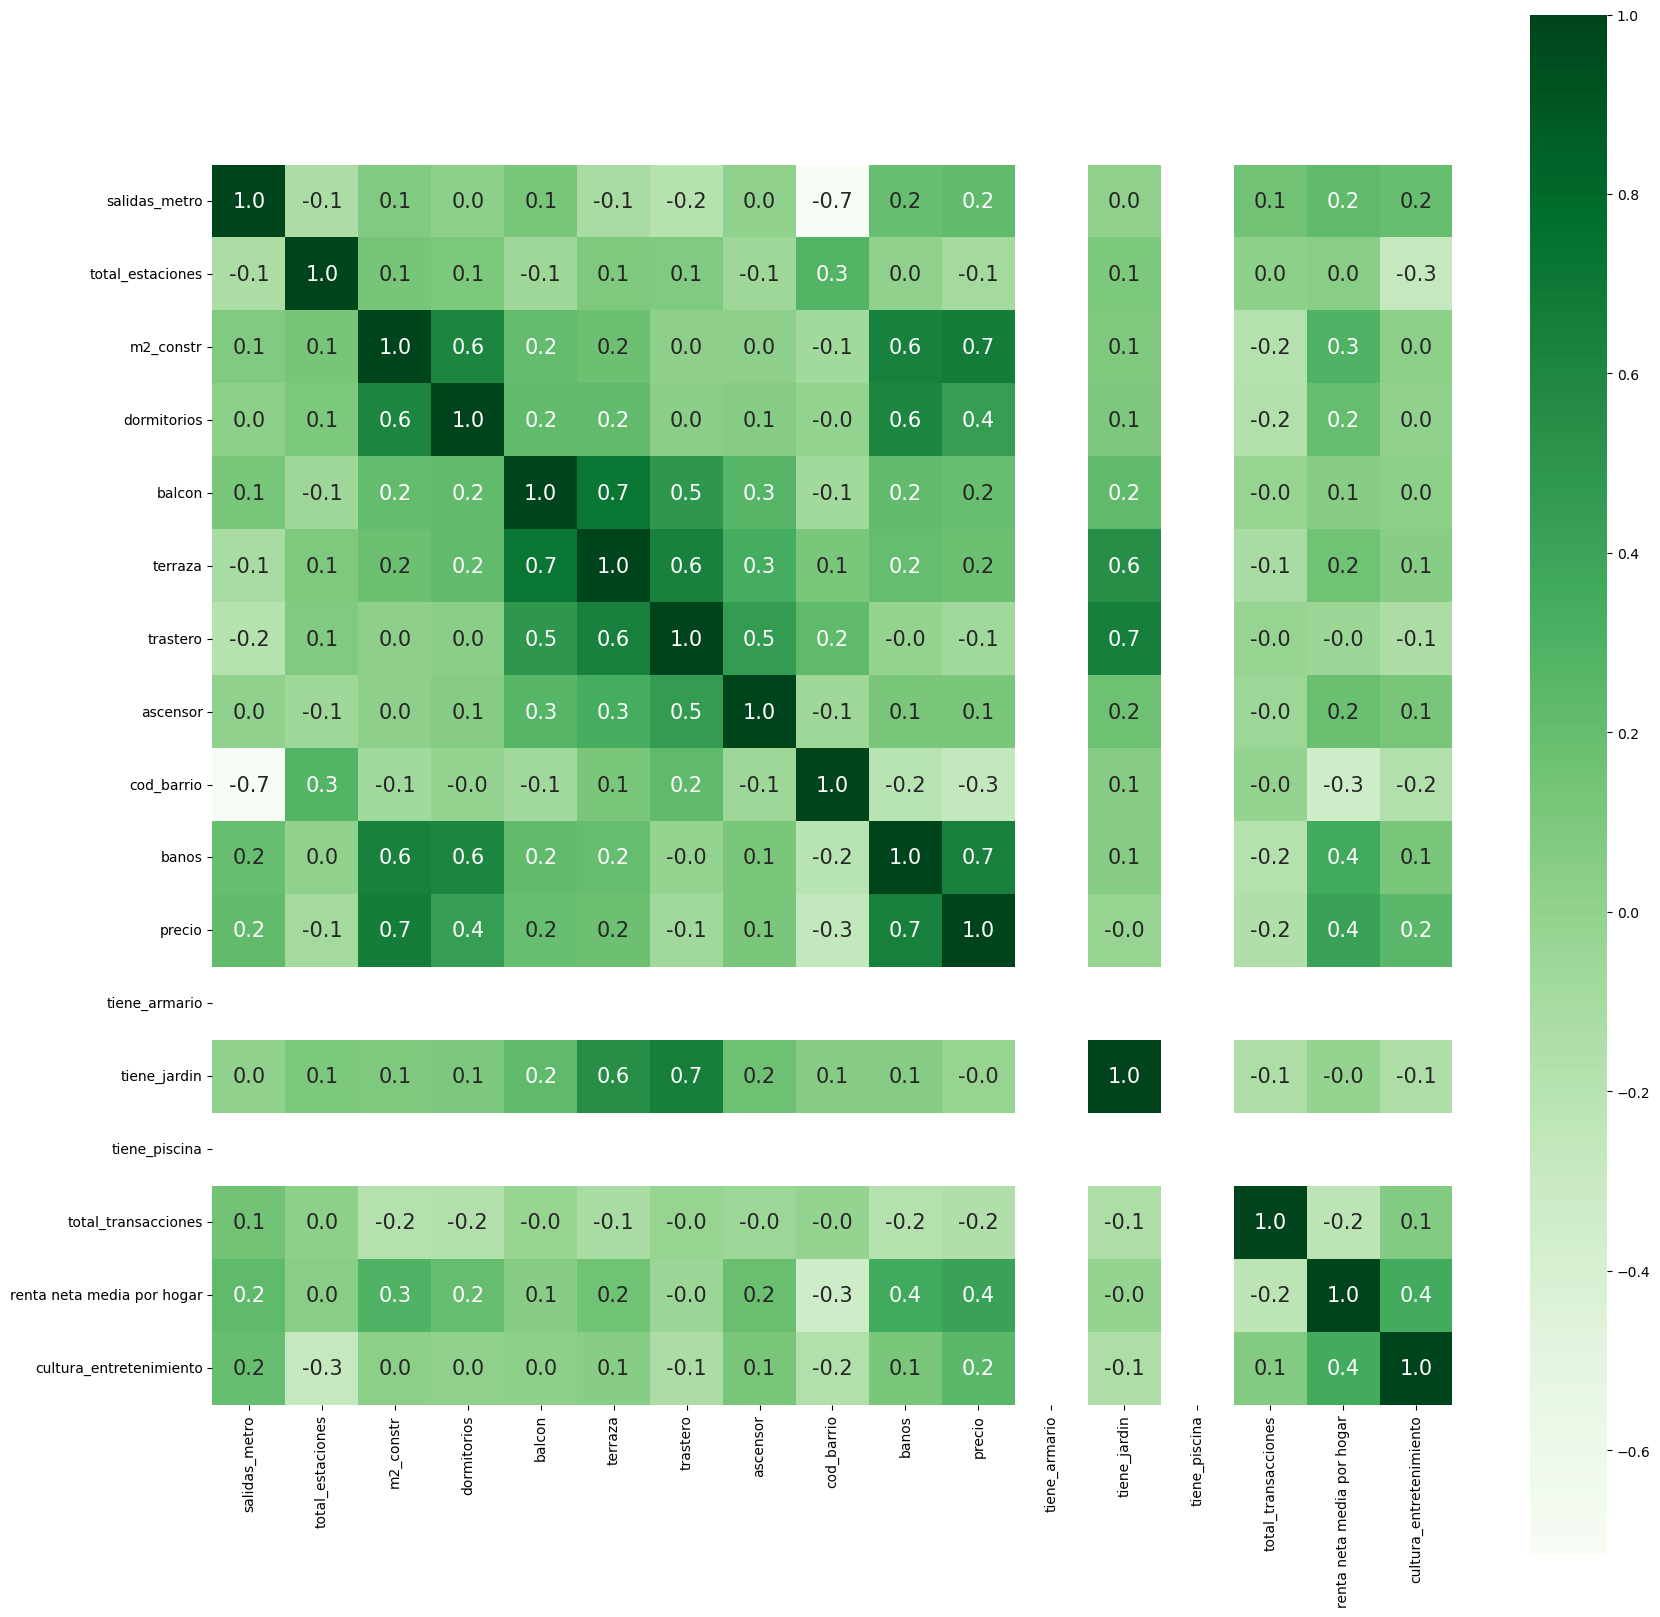

In [50]:
# Plotting the heatmap of correlation between features
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

In [ ]:
# Scatter plots between all features
#import warnings
#warnings.filterwarnings("ignore")  

#sns.pairplot(data=dfb)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001E106F01800> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
cols=['url','total_estaciones','m2_constr', 'dormitorios', 'balcon', 'terraza', 'trastero', 'ascensor','cod_barrio', 'banos', 'precio', 'tiene_armario','tiene_jardin','tiene_piscina','total_transacciones','renta neta media por hogar','cultura_entretenimiento']
df=dfb[cols]

In [ ]:
print(f"El DataFrame dfEDA tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

El DataFrame dfEDA tiene 10012 filas y 16 columnas.


In [ ]:
### 2.3 Partición en train / test

In [ ]:
df.precio.describe(percentiles=[0.15,0.3,0.45,0.55,0.75,0.9])

In [ ]:
# Guardamos la  variable target en una variable "target"
target = 'precio' 
df[target].head()

In [ ]:
dfbaseline=df
# Dividir las columnas objetivo y características, preservando nombres de columnas
y = dfbaseline[target].values
X = dfbaseline.drop(columns=[target, 'url'])
df_ids = dfbaseline[['url']]

# Primera clasificación entre train y test
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, df_ids, test_size=0.2, random_state=42, stratify=y)

#Segunda división: Train y Validación a partir de X_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Número de registros del dataset de train y de test
print("Número de observaciones")
print("- Train: ", X_train.shape[0])
print("- Test:  ", X_test.shape[0])
print("- Val:  ", X_val.shape[0])

dftrain = X_train.reset_index(drop=True)
dftest = X_test.reset_index(drop=True)
dfval = X_val.reset_index(drop=True)

# establezco el conjunto train y test para CatBoost
X_train_Catboost =dftrain.iloc[:, :54]
X_test_Catboost = dftest.iloc[:, :54] 
X_val_Catboost = dfval.iloc[:, :54] 

#Establezco train y test para el DecisionTree

X_train_1=dftrain.drop(columns = cols_cat)
X_test_1=dftest.drop(columns = cols_cat)
X_val_1=dfval.drop(columns = cols_cat)

In [ ]:
# Spliting target variable and independent variables
X = df.drop([housing['target_names'][0]], axis = 1)
y = df[housing['target_names'][0]]

# Splitting to training and testing df
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
## 3. Regresión Lineal

### 3.1 Entrenamiento del modelo

In [ ]:
# Import library for Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets 
lm.fit(X_train, y_train)

In [ ]:
# Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns, lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

In [ ]:
### 3.2 Evaluación sobre train

In [ ]:
# Model prediction on train df
y_pred = lm.predict(X_train)

In [ ]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

- **𝑅^2**: Es una medida de la relación lineal entre X e Y. Se interpreta como la proporción de la varianza en la variable dependiente que es predecible a partir de la variable independiente.

- **MAE**: Es la media del valor absoluto de los errores. Mide la diferencia entre dos variables continuas, en este caso, los valores reales y los valores predichos de y.

- **MSE**: El error cuadrático medio (MSE, por sus siglas en inglés) es similar al MAE, pero eleva al cuadrado la diferencia antes de sumarlas todas, en lugar de usar el valor absoluto.

- **RMSE**: La raíz cuadrada del error cuadrático medio (RMSE, por sus siglas en inglés) es la raíz cuadrada del MSE.

In [ ]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

In [ ]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# Checking Normality of errors
sns.displot(y_train-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

### 3.3 Evaluación sobre test

In [ ]:
# Predicting Test df with the model
y_test_pred = lm.predict(X_test)

In [ ]:
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# **_4. Exploración de datos_**

In [ ]:
df.head(2)

,salidas_metro,total_estaciones,m2_constr,dormitorios,balcon,terraza,trastero,ascensor,cod_barrio,banos,precio,tiene_armario,tiene_jardin,tiene_piscina,total_transacciones,renta neta media por hogar,cultura_entretenimiento
0,18.00,205.00,100.00,1.00,1.00,1.00,1.00,1.00,41,1,2000000,NaN,NaN,1.00,243.00,64.92,917.00
1,20.00,296.00,74.00,1.00,NaN,NaN,0.00,1.00,54,1,650000,NaN,0.00,1.00,311.00,74.84,220.00


In [ ]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
salidas_metro,10012.00,15.62,7.26,4.00,9.00,16.00,20.00,27.00
total_estaciones,10012.00,246.37,77.22,143.00,201.25,210.00,305.00,469.00
m2_constr,10012.00,138.58,152.03,0.00,68.00,98.00,150.00,4574.00
dormitorios,9838.00,2.82,1.43,0.00,2.00,3.00,3.00,24.00
balcon,1410.00,0.59,0.49,0.00,0.00,1.00,1.00,1.00
terraza,2449.00,0.77,0.42,0.00,1.00,1.00,1.00,1.00
trastero,2636.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
ascensor,4564.00,0.91,0.29,0.00,1.00,1.00,1.00,1.00
cod_barrio,10012.00,81.43,57.64,11.00,41.00,65.00,124.00,215.00
banos,10012.00,1.99,1.37,0.00,1.00,2.00,3.00,31.00


In [ ]:
df.isnull().sum()

salidas_metro                    0
total_estaciones                 0
m2_constr                        0
dormitorios                    174
balcon                        8602
terraza                       7563
trastero                      7376
ascensor                      5448
cod_barrio                       0
banos                            0
precio                           0
tiene_armario                 8135
tiene_jardin                  7990
tiene_piscina                 6606
total_transacciones              0
renta neta media por hogar       0
cultura_entretenimiento          0
dtype: int64

## 4.1 Tipo de datos

In [ ]:
# Función `columnas_por_tipo` que muestra un resumen de los tipo de columnas que hay en el dataframe
# boolean_columns, numeric_cols, cat_columns, object_columns, other_columns
cols_bool, cols_num, cols_cat, cols_obj, cols_other = columnas_por_tipo(dfEDA)
print("Booleans:", cols_bool)
print("Numéricas:", cols_num)
print("Categóricas:", cols_cat)
print("Objeto:", cols_obj)
print("Otras:", cols_other)

Número de columnas de tipo entero: 5
Columnas de tipo entero: ['cod_distrito', 'cod_barrio', 'banos', 'precio', 'armarios']
Número de columnas de tipo float: 77
Columnas de tipo float: ['m2_constr', 'dormitorios', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'inmueble_ingresos', 'alquiler_opcion_a_compra', 'nuda_propiedad', 'tiene_armario', 'cancha_tenis', 'carpinteria_exterior_doble_vidrio/pvc', 'carpinteria_exterior_doble_vidrio/madera', 'carpinteria_exterior_doble_vidrio/metal', 'carpinteria_exterior_triple_vidrio/madera', 'carpinteria_exterior_triple_vidrio/metal', 'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/madera', 'carpinteria_exterior_vidrio/metal', 'chimenea', 'exterior', 'interior', 'interior_y_exterior', 'porton_electrico', 'videoportero', 'acceso_discapacidad', 'codigo_postal', 'm2_utiles', 'tiene_jardin', 'num_visitas', 'puerta_seguridad', 'tiene_piscina', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'n

## 4.2 Identificacion de valores nulos


Identificación de Valores Nulos

Los valores nulos pueden afectar los análisis estadísticos y las visualizaciones. Para detectarlos, revisaremos:
- La cantidad de valores nulos por columna.
- El porcentaje de valores nulos en relación con el total de datos.
- Visualización de los valores nulos para identificar patrones.

### 4.2.1 Número de valores nulos por columna

In [ ]:
# Verificar valores nulos por columna
valores_nulos = dfEDA.isnull().sum()

print("Valores nulos por columna:")
print(valores_nulos[valores_nulos > 0])

Valores nulos por columna:
letra_ce                                      7885
estado                                        4515
amueblado                                     8816
planta                                        4556
dormitorios                                    225
balcon                                        8619
terraza                                       7580
garaje                                        8066
trastero                                      7388
ascensor                                      5461
antiguedad                                    6636
num_plantas                                   9819
jardin                                        7999
inmueble_ingresos                            10025
alquiler_opcion_a_compra                     10032
nuda_propiedad                               10023
tipo_inmueble                                 8143
tiene_armario                                 8151
cancha_tenis                                  6987
carp

### 4.2.2 Porcentaje de nulos por columna

In [ ]:
# Ver porcentaje de valores nulos
porcentaje_nulos = (dfEDA.isnull().sum() / len(dfEDA)) * 100

print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos[porcentaje_nulos > 0])


Porcentaje de valores nulos por columna:
letra_ce                                    78.57
estado                                      44.99
amueblado                                   87.85
planta                                      45.40
dormitorios                                  2.24
balcon                                      85.89
terraza                                     75.54
garaje                                      80.38
trastero                                    73.62
ascensor                                    54.42
antiguedad                                  66.13
num_plantas                                 97.85
jardin                                      79.71
inmueble_ingresos                           99.90
alquiler_opcion_a_compra                    99.97
nuda_propiedad                              99.88
tipo_inmueble                               81.15
tiene_armario                               81.23
cancha_tenis                                69.63
carpinte

## 4.2.3 Visulización de nulos

In [ ]:

# Convertir valores nulos en 1 y valores no nulos en 0
df_nulos = dfEDA.isnull().astype(int)

# Graficar con imshow (MUCHO MÁS RÁPIDO)
fig = px.imshow(df_nulos, labels={'x': 'Columnas', 'y': 'Índices', 'color': 'Nulo'},
                color_continuous_scale='blues', title="Mapa de Valores Nulos")
#silvia comento los graficos para que no pese, quitar el comentario para analizarlos
#fig.show()


# **_5. Variable target_**


In [ ]:
# Distribución de la variable target en porcentaje
dfEDA["precio"].value_counts(normalize = True)

precio
220000    0.01
230000    0.01
280000    0.01
240000    0.01
650000    0.01
          ... 
3090000   0.00
691900    0.00
296900    0.00
317900    0.00
69313     0.00
Name: proportion, Length: 1593, dtype: float64

In [ ]:
dfEDA.precio.describe(percentiles=[0.15,0.3,0.45,0.55,0.75,0.9])

count      10035.00
mean      889074.50
std      1159555.24
min        25000.00
15%       185000.00
30%       269000.00
45%       402930.00
50%       480000.00
55%       580000.00
75%      1090000.00
90%      1990000.00
max     19950000.00
Name: precio, dtype: float64

In [ ]:
df.drop_duplicates(keep='first', inplace=True)

# 5.2 Distribución

In [ ]:
# HISTOGRAMA
fig = px.histogram(dfEDA,x="precio", nbins=100,title='Precio en Euros', labels={'value': 'Precio'})
fig.show()

#### 🚩
Explicación de las gráficas

En el grafico mostrado se puede visualizar claramente la distribucion de las viviendas segun su precio. Gracias a ello podemos percatarnos que hay una notable mayor cantidad de viviendas con un rango de 200 k - 400 k euros a a diferencia de las demas viviendas donde la cantidad de las mismas empieza a disminuir. Tambien se puede notar que hay varios outliers o en otras palabras viviendas que salen considerablemente de donde se encuentra el mayor numero de viviendas teniendo un precio sumamente mayor al de donde se encuentran el mayor numero de viviendas.  En conclusion, el mayor numero de viviendas se concentra en valores menores a 1 millon de euros y tenemos viviendas con precios que pueden llegar a ser mayores a 18 millones de euros lo que es algo poco comun.

# Modelo lo baseline

In [ ]:
dfbaseline=df

# Dividir las columnas objetivo y características, preservando nombres de columnas
y = dfbaseline[target].values
X = dfbaseline.drop(columns=[target, 'machineidentifier'])

df_ids = dfbaseline[['url']]

# Primera clasificación entre train y test
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, df_ids, test_size=0.2, random_state=42, stratify=y)
# Número de registros en cada conjunto
print("Número de observaciones")
print("- Train:      ", X_train.shape[0])
print("- Test:       ", X_test.shape[0])

In [ ]:
# Dividir las columnas objetivo y características, preservando nombres de columnas
y = dfbaseline[target].values
X = dfbaseline.drop(columns=[target,'url'])

df_ids = dfbaseline[['url']]

# Primera clasificación entre train y test
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, df_ids, test_size=0.2, random_state=42, stratify=y)
# Número de registros en cada conjunto
print("Número de observaciones")
print("- Train:      ", X_train.shape[0])
print("- Test:       ", X_test.shape[0])

# Entrenamiento

In [ ]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from scipy.stats import randint
import numpy as np

# Instanciamos los modelos y los almacenamos en un diccionario
# junto con los hiperparámetros que queramos optimizar
regressors = {
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', n_jobs=-1), 
        'hyperparameters': {
          'max_depth': randint(2, 6),
          'n_estimators': randint(10, 100),
          'learning_rate': [0.1, 0.05, 0.01],
          'subsample': np.linspace(0.1, 1, 10)  # Valores entre 0.1 y 1 (10 valores posibles)
        } # https://xgboost.readthedocs.io/en/stable/parameter.html
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(), 
        'hyperparameters': {
            'criterion': ["squared_error", "friedman_mse"],
            'max_depth': randint(2, 10),
            'min_samples_leaf': randint(1, 5)
        } # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    },
    'RandomForest': {
        'model': RandomForestRegressor(n_jobs=-1), 
        'hyperparameters': {
          'max_depth': randint(2, 10),
          'min_samples_leaf': randint(1, 5),
          'n_estimators': randint(10, 120)
        } # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    }, 
    'GradientBoosting': {
        'model': GradientBoostingRegressor(), 
        'hyperparameters': {
          'max_depth': randint(2, 12),
          'min_samples_leaf': randint(1, 5),
          'learning_rate': [0.2, 0.1, 0.01],
          'n_estimators': randint(10, 120)
        } # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0), 
        'hyperparameters': {
          'depth': randint(2, 10),
          'learning_rate': [0.2, 0.1, 0.01],
          'iterations': randint(10, 100)
        } # https://catboost.ai/docs/concepts/python-reference_parameters-list.html
    }
}


In [ ]:
random_search_output = list()
best_estimators = {}

for reg_name, reg_info in regressors.items():  # Cambia classifiers por regressors
    print(reg_name)
    reg_random_search = RandomizedSearchCV(
        estimator=reg_info['model'], 
        param_distributions=reg_info['hyperparameters'], 
        n_iter=20,
        cv=3,
        scoring="neg_mean_squared_error",  # Métrico adecuado para regresión
        return_train_score=True,
        refit=True,
        n_jobs=-1,
        verbose=1
    )
    reg_random_search.fit(X_train, y_train)
    
    # Resultados del Random Search
    df_output = pd.DataFrame(reg_random_search.cv_results_)
    df_output['regressor'] = reg_name
    random_search_output.append(df_output)
    
    # Modelo re-entrenado con los hiperparámetros óptimos
    best_estimators[reg_name] = reg_random_search.best_estimator_


In [ ]:
# Concatenamos todos los resultados para cada modelo
df_results = pd.concat(random_search_output).reset_index(drop=True)

# Columnas de resultados del cross-validation para regresión
split_test_score_columns = ['split0_test_score', 'split1_test_score', 'split2_test_score']

# Ajustamos las columnas para reflejar los datos de regresión
df_results = df_results[
    ['regressor', 'rank_test_score', 'mean_train_score', 'mean_test_score', 'std_test_score', 'params']
    + split_test_score_columns
]

# Mostramos una muestra aleatoria de 20 resultados
df_results.sample(20)


In [ ]:
# Nos quedamos con el mejor modelo de cada tipo para regresión
df_best = (
    df_results
    .query('rank_test_score == 1')  # Mantiene los modelos con el mejor ranking
    .drop_duplicates(['regressor', 'rank_test_score'])  # Reemplaza 'clf' por 'regressor'
    .sort_values('mean_test_score', ascending=False)  # Ordenamos por el score promedio
    .reset_index(drop=True)  # Reiniciamos el índice
)
df_best


In [ ]:
# Transponer el DataFrame para que cada modelo sea una columna
df_transposed = df_best[split_test_score_columns].T

# Crear el boxplot usando Seaborn
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_transposed)
plt.ylabel("neg_mean_squared_error")  # Cambiado para reflejar la métrica de regresión

plt.title("Boxplot de los scores en test del mejor modelo de cada tipo (Regresión)")
# Añadir etiquetas al eje x
plt.xticks(ticks=range(len(df_transposed.columns)), labels=df_best["regressor"])  # Cambiar 'clf' por 'regressor'
plt.show()


In [ ]:
for i, r in df_best.iterrows():
    print(r.regressor, "=>", np.round(r.mean_test_score, 4), "\u00B1", np.round(r.std_test_score, 4))


In [ ]:
    # Escogemos el mejor modelo de todos 
best_model= best_estimators['GradientBoosting']

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Definir rango para max_depth
max_max_depth = 41
l_mse_train = list()
l_mse_test = list()
l_r2_train = list()
l_r2_test = list()

for i in range(2, max_max_depth):
    # Entrenar modelo
    reg = DecisionTreeRegressor(max_depth=i)
    reg.fit(X_train, y_train)
    
    # Métricas para el conjunto de entrenamiento
    y_pred_train = reg.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    l_mse_train.append(mse_train)
    l_r2_train.append(r2_train)
    
    # Métricas para el conjunto de prueba
    y_pred_test = reg.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    l_mse_test.append(mse_test)
    l_r2_test.append(r2_test)

# Graficar evolución del MSE
plt.figure(figsize=(15, 5))
plt.plot(range(2, max_max_depth), l_mse_train, label='Train MSE')
plt.plot(range(2, max_max_depth), l_mse_test, label='Test MSE')
plt.title("Evolución del MSE")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Graficar evolución de R²
plt.figure(figsize=(15, 5))
plt.plot(range(2, max_max_depth), l_r2_train, label='Train R²')
plt.plot(range(2, max_max_depth), l_r2_test, label='Test R²')
plt.title("Evolución de R²")
plt.xlabel("max_depth")
plt.ylabel("R²")
plt.legend()
plt.show()


Gráfico de predicciones frente a valores reales: Esto muestra cómo las predicciones del modelo se alinean con los valores reales (idealmente, deberían seguir una línea diagonal).

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Gráfico de predicciones vs valores reales")
plt.show()


Error residual: Graficar los residuos (diferencia entre valores reales y predichos) para identificar patrones que sugieran falta de calibración.

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos")
plt.show()


Gráfico de distribuciones: Verificar si la distribución de los errores es aproximadamente normal.

In [ ]:
sns.histplot(y_test - y_pred, kde=True, bins=30)
plt.title("Distribución de los errores (residuos)")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.show()


Métricas clave de error: Calcular métricas como MAE (Mean Absolute Error), MSE (Mean Squared Error) o RMSE (Root Mean Squared Error) para evaluar el desempeño.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


In [ ]:
# Obtener la importancia de las características
importances = best_model_2.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Seleccionar las 10 características más importantes
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = X_train.columns[top_indices]

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances, align="center")
plt.yticks(range(top_n), top_features)
plt.xlabel("Importancia")
plt.title("Importancia de las 10 características más importantes")
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicciones
y_pred = best_model_2.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Visualización: valores reales vs predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Valores predichos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Línea ideal")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs. Predicciones")
plt.legend()
plt.show()

# Visualización: residuos
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.show()



¡Sí! **SHAP** (SHapley Additive exPlanations) también es válido y muy útil para modelos de regresión. El proceso sigue siendo prácticamente el mismo que para clasificación, pero con algunos ajustes en la interpretación:

1. **Salidas SHAP en regresión**:
   - En lugar de explicar probabilidades o clasificaciones, los valores SHAP explicarán las **predicciones continuas** del modelo, como la cantidad en euros o cualquier métrica de tu variable objetivo.

2. **Predicción en regresión**:
   - En vez de `output_margin=True` (que se usa para trabajar en la escala de logits en clasificación), puedes simplemente usar las predicciones directas del modelo (`y_pred = best_model.predict(X_train)`) y comparar los valores SHAP con esas predicciones continuas.

3. **Interpretación de las contribuciones**:
   - Los valores SHAP muestran cómo cada característica contribuye a aumentar o disminuir el valor predicho para cada muestra. Esto te ayuda a entender, por ejemplo, si una característica aumenta el precio de una vivienda o si lo reduce, y en qué magnitud.

4. **Visualización en regresión**:
   Puedes usar las mismas visualizaciones que con clasificación:
   - Resumen global:
     ```python
     shap.summary_plot(shap_values.values, X_train)
     ```
   - Dependencia parcial:
     ```python
     shap.dependence_plot("feature_name", shap_values.values, X_train)
     ```
   - Fuerza individual (para una muestra específica):
     ```python
     shap.force_plot(explainer.expected_value, shap_values.values[0], X_train.iloc[0])
     ```

### Validación del código:
El siguiente fragmento sigue siendo válido para regresión, solo ajustando cómo obtienes las predicciones para comparación:
```python
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_train)  # Obtención de valores SHAP
y_pred_raw = best_model.predict(X_train)  # Predicciones directas del modelo
# Validar que los SHAP values sumen las predicciones
np.abs(shap_values.values.sum(axis=1) + shap_values.base_values - y_pred_raw).max()
```

Si `np.abs(...).max()` devuelve `0.0` o un valor cercano a cero, los valores SHAP están correctamente calculados.

### En resumen:
**SHAP es completamente válido y poderoso para regresión.** Te ofrece la capacidad de entender qué características tienen mayor impacto en las predicciones continuas del modelo. Si necesitas ayuda para personalizar visualizaciones o análisis, estoy lista para ayudarte 😊.

Enviar un mensaje a Copilot